In [1]:
Corpus = '''
elma suyu 
portakal suyu
vişne suyu
kayısı suyu

facebook şirketi
google şirketi
microsoft şirketi
mcdonalds şirketi
yahoo şirketi
'''

In [2]:
cumleler = [cumle for cumle in Corpus.split('\n') if cumle !='']
cumleler

['elma suyu ',
 'portakal suyu',
 'vişne suyu',
 'kayısı suyu',
 'facebook şirketi',
 'google şirketi',
 'microsoft şirketi',
 'mcdonalds şirketi',
 'yahoo şirketi']

In [3]:
import pandas as pd

veriseti = [cumle.split() for cumle in cumleler]
veriseti = pd.DataFrame(veriseti, columns = ['girdi', 'cikti'])
veriseti

,girdi,cikti
0,elma,suyu
1,portakal,suyu
2,vişne,suyu
3,kayısı,suyu
4,facebook,şirketi
5,google,şirketi
6,microsoft,şirketi
7,mcdonalds,şirketi
8,yahoo,şirketi


In [4]:
kelimeler = list(veriseti.girdi) + list(veriseti.cikti)
tekil_kelimeler = set(kelimeler)
tekil_kelimeler

{'elma',
 'facebook',
 'google',
 'kayısı',
 'mcdonalds',
 'microsoft',
 'portakal',
 'suyu',
 'vişne',
 'yahoo',
 'şirketi'}

In [5]:
pozitif = veriseti.copy()
for i in range(10):
    ekle = veriseti.copy()
    pozitif = pd.concat((pozitif, ekle))
pozitif

,girdi,cikti
0,elma,suyu
1,portakal,suyu
2,vişne,suyu
3,kayısı,suyu
4,facebook,şirketi
...,...,...
4,facebook,şirketi
5,google,şirketi
6,microsoft,şirketi
7,mcdonalds,şirketi


In [6]:
veri = pozitif

In [7]:
id2tok = dict(enumerate(tekil_kelimeler))
tok2id = {token: id for id, token in id2tok.items()}

In [8]:
id2tok

{0: 'vişne',
 1: 'facebook',
 2: 'google',
 3: 'elma',
 4: 'yahoo',
 5: 'portakal',
 6: 'mcdonalds',
 7: 'suyu',
 8: 'microsoft',
 9: 'şirketi',
 10: 'kayısı'}

In [9]:
X = veri[['girdi', 'cikti']].copy()
X.girdi = X.girdi.map(tok2id)
X.cikti = X.cikti.map(tok2id)
X

,girdi,cikti
0,3,7
1,5,7
2,0,7
3,10,7
4,1,9
...,...,...
4,1,9
5,2,9
6,8,9
7,6,9


In [10]:
from torch.utils.data import Dataset, DataLoader

# defining the Dataset class
class data_set(Dataset):
    def __init__(self, veri):
        X = veri[['girdi', 'cikti']].copy()
        
        X.girdi = X.girdi.map(tok2id)
        X.cikti = X.cikti.map(tok2id)
        
        self.X = X.girdi.values
        self.y = X.cikti.values

    def __len__(self):
        return len(self.X)
  
    def __getitem__(self, index):
        return self.X[index], self.y[index]
  
  
dataset = data_set(veri)

In [11]:
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
for i, (batch_X, batch_y) in enumerate(dataloader):
    print(i, batch_X, batch_y)
    if i >= 2: break

0 tensor([2, 8, 0, 3, 4, 5, 1, 4]) tensor([9, 9, 7, 7, 9, 7, 9, 9])
1 tensor([4, 5, 2, 5, 2, 6, 1, 8]) tensor([9, 7, 9, 7, 9, 9, 9, 9])
2 tensor([10,  5,  4,  5,  1,  6,  1,  2]) tensor([7, 7, 9, 7, 9, 9, 9, 9])


In [12]:
import torch
from torch import nn

class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.expand = nn.Linear(embedding_size, vocab_size, bias=False)

    def forward(self, input):
        # Encode input to lower-dimensional representation
        hidden = self.embed(input)
        # Expand hidden layer to predictions
        logits = self.expand(hidden)
        return logits

In [13]:
EMBED_SIZE = 2 # Quite small, just for the tutorial
n_v = len(tekil_kelimeler)

model = Word2Vec(n_v, EMBED_SIZE)

# Relevant if you have a GPU:
#device = torch.device('mps')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define training parameters
LR = 3e-4
EPOCHS = 1000
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

In [14]:
from tqdm import tqdm  # For progress bars

progress_bar = tqdm(range(EPOCHS * len(dataloader)))
running_loss = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for i, (batch_X, batch_y) in enumerate(dataloader):
        center, context = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        logits = model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    epoch_loss /= len(dataloader)
    running_loss.append(epoch_loss)

100%|███████████████████████████████████████████████████████████████████████████| 13000/13000 [00:30<00:00, 815.77it/s]

In [15]:
wordvecs =  model.expand.weight.cpu().detach().numpy()
wordvecs

array([[ 0.90861523, -1.0241102 ],
       [ 0.1019879 ,  0.95454717],
       [-0.6393202 , -0.27465203],
       [ 0.84155154, -1.0583595 ],
       [-0.42323968,  0.08040249],
       [ 1.6601901 , -0.5762606 ],
       [-0.23178625,  0.4047652 ],
       [ 1.7651389 ,  1.1581658 ],
       [-0.2536947 ,  0.35712877],
       [ 2.1034584 ,  1.5006914 ],
       [ 1.2151265 , -0.8439137 ]], dtype=float32)

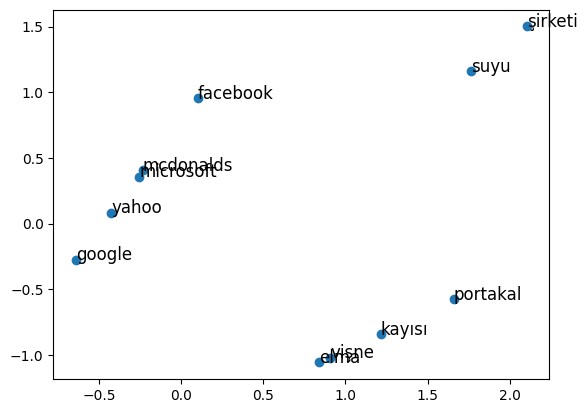

In [16]:
import matplotlib.pyplot as plt
def plotit(wordvecs):
    plt.plot(wordvecs[:,0], wordvecs[:,1], 'o')

    for i, cord in enumerate(wordvecs):
        plt.text(cord[0], cord[1], id2tok[i], fontsize=12)

plotit(wordvecs)

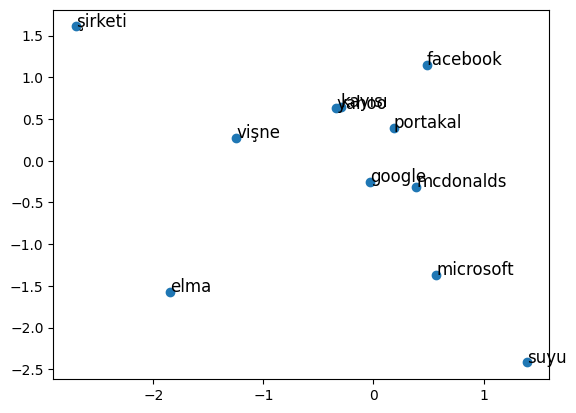

In [17]:
wordvecs_input =  model.embed.weight.cpu().detach().numpy()
plotit(wordvecs_input)

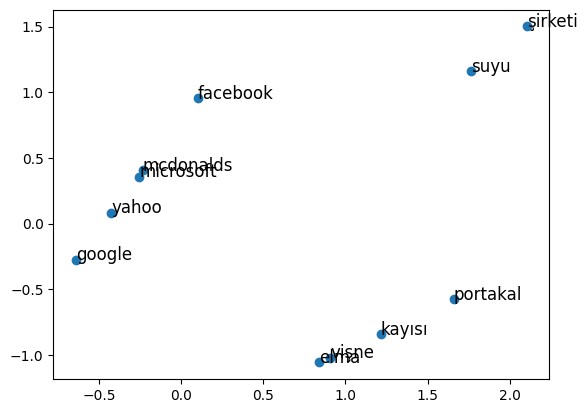

In [18]:
wordvecs_input =  model.expand.weight.cpu().detach().numpy()
plotit(wordvecs_input)

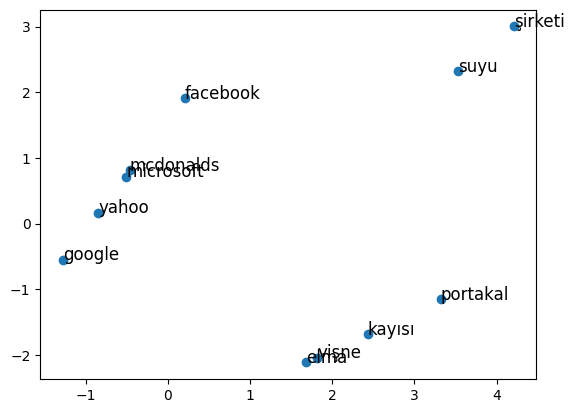

In [19]:
plotit(wordvecs_input + wordvecs)

In [20]:
digeryon = pozitif.copy()
digeryon.girdi = pozitif.cikti
digeryon.cikti = pozitif.girdi
digeryon

,girdi,cikti
0,suyu,elma
1,suyu,portakal
2,suyu,vişne
3,suyu,kayısı
4,şirketi,facebook
...,...,...
4,şirketi,facebook
5,şirketi,google
6,şirketi,microsoft
7,şirketi,mcdonalds


In [21]:
veri = digeryon

In [22]:
dataset = data_set(veri)

In [23]:
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
for i, (batch_X, batch_y) in enumerate(dataloader):
    print(i, batch_X, batch_y)
    if i >= 2: break

0 tensor([9, 9, 9, 7, 9, 9, 7, 7]) tensor([ 6,  4,  8, 10,  6,  8,  5,  5])
1 tensor([9, 9, 9, 7, 9, 9, 9, 9]) tensor([1, 1, 8, 3, 1, 2, 8, 1])
2 tensor([9, 7, 9, 7, 9, 9, 7, 9]) tensor([ 2,  5,  2, 10,  1,  4,  0,  6])


In [24]:
X = veri[['girdi', 'cikti']].copy()
X.girdi = X.girdi.map(tok2id)
X.cikti = X.cikti.map(tok2id)
X

,girdi,cikti
0,7,3
1,7,5
2,7,0
3,7,10
4,9,1
...,...,...
4,9,1
5,9,2
6,9,8
7,9,6


In [26]:
from tqdm import tqdm  # For progress bars

progress_bar = tqdm(range(EPOCHS * len(dataloader)))
running_loss = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for i, (batch_X, batch_y) in enumerate(dataloader):
        center, context = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        logits = model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    epoch_loss /= len(dataloader)
    running_loss.append(epoch_loss)


100%|██████████████████████████████████████████████████████████████████████████▉| 12990/13000 [00:17<00:00, 504.67it/s]

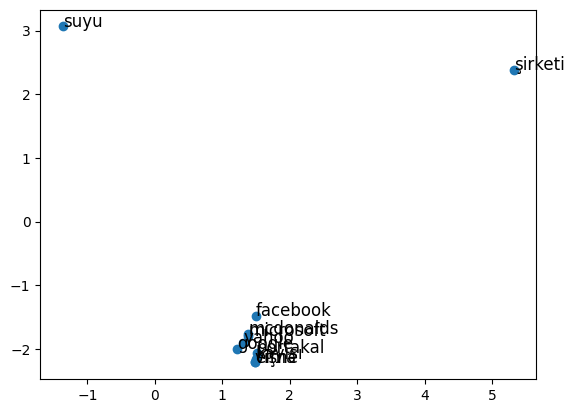

In [27]:
wordvecs =  model.expand.weight.cpu().detach().numpy()
plotit(wordvecs)

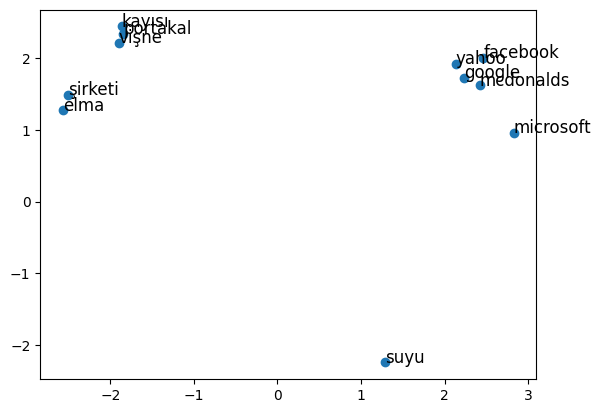

In [28]:
wordvecs_input =  model.embed.weight.cpu().detach().numpy()
plotit(wordvecs_input)

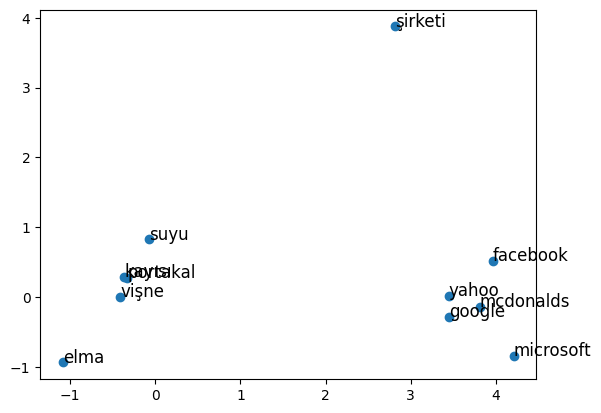

In [29]:
plotit(wordvecs_input + wordvecs)

In [30]:
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('C:/Users/user/Downloads/trmodel', binary=True)


100%|███████████████████████████████████████████████████████████████████████████| 13000/13000 [00:36<00:00, 504.67it/s]

In [31]:
word_vectors.most_similar(positive=["kral","kadın"],negative=["erkek"])

[('kraliçe', 0.508816123008728),
 ('kralı', 0.4718089997768402),
 ('kralın', 0.44512391090393066),
 ('kraliçesi', 0.4190150797367096),
 ('prenses', 0.4071305990219116),
 ('hükümdar', 0.4056030511856079),
 ('prens', 0.3978962004184723),
 ('kraliçenin', 0.39632880687713623),
 ('veliaht', 0.38219931721687317),
 ('tahtı', 0.3773398697376251)]

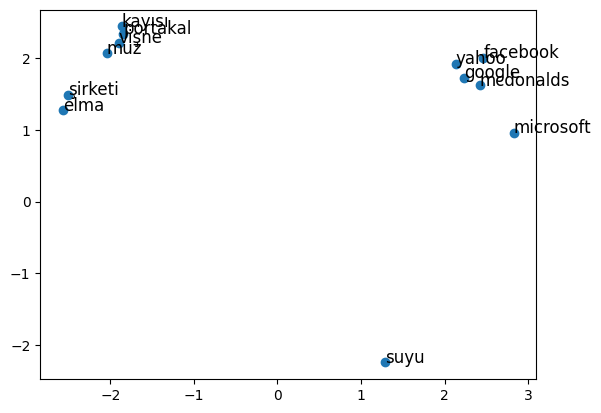

In [32]:
new_word = 'muz'
new_id = len(tekil_kelimeler) # 11
id2tok[new_id] = new_word
tok2id[new_word] = new_id

# Adım 2: Yeni kelime ile ilişkili olabilecek kelimelerin vektörlerini al
related_words = ['elma', 'portakal', 'vişne', 'kayısı']
related_ids = [tok2id[word] for word in related_words]
related_vectors = model.embed(torch.tensor(related_ids).to(device)) # embed katmanından vektörleri al

# Adım 3: Bu vektörlerin ortalamasını al
new_vector = torch.mean(related_vectors, dim=0) # boyut 0 üzerinden ortalama al

# Adım 4: Modelin embed ve expand katmanlarındaki ağırlık matrislerine yeni kelimenin vektörünü ekle
model.embed.weight = torch.nn.Parameter(torch.cat((model.embed.weight, new_vector.unsqueeze(0)), dim=0)) # embed katmanına ekle
model.expand.weight = torch.nn.Parameter(torch.cat((model.expand.weight, new_vector.unsqueeze(0)), dim=0)) # expand katmanına ekle

# Adım 5: Yeni kelimenin vektörünü plotit fonksiyonu ile görselleştir
wordvecs_input =  model.embed.weight.cpu().detach().numpy()
plotit(wordvecs_input)


Epoch 0, Loss: 59.91
Epoch 100, Loss: 34.08
Epoch 200, Loss: 31.03
Epoch 300, Loss: 28.78
Epoch 400, Loss: 28.33
Epoch 500, Loss: 27.55
Epoch 600, Loss: 26.09
Epoch 700, Loss: 24.34
Epoch 800, Loss: 26.64
Epoch 900, Loss: 28.39


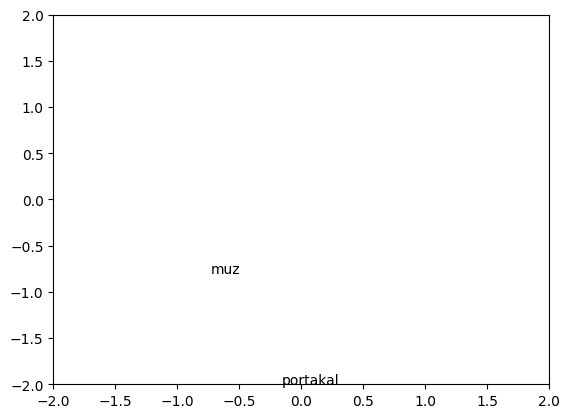

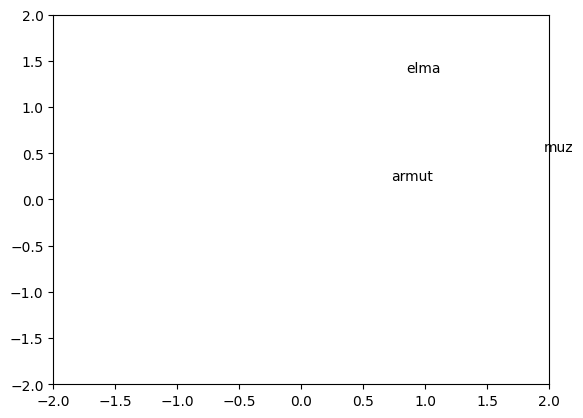

In [33]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Örnek veri
data = ["elma armut muz", "armut portakal", "muz elma armut", "portakal armut","google şirket","facebook şirket"]

# Kelimeleri ayırın
kelimeler = []
for cumle in data:
    kelimeler.extend(cumle.split())

# Tekil kelimeleri alın
tekil_kelimeler = set(kelimeler)

# Kelimi sayılara dönüştürün
tok2id = {tok: i for i, tok in enumerate(tekil_kelimeler)}
id2tok = {i: tok for tok, i in tok2id.items()}
data = [tok2id[tok] for tok in kelimeler]

# Hyperparametreler
EMBED_SIZE = 2
LR = 0.01
EPOCHS = 1000
NUM_NEG_SAMPLES = 5

# Negative örneklerin seçilmesi için bir fonksiyon
def get_negative_samples(batch_size, num_neg_samples, vocab_size):
    negative_samples = np.random.randint(0, vocab_size, (batch_size, num_neg_samples))
    return torch.tensor(negative_samples, dtype=torch.long)

# Model sınıfı
class Word2VecNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super(Word2VecNegativeSampling, self).__init__()
        self.input_embed = nn.Embedding(vocab_size, embedding_size)
        self.output_embed = nn.Embedding(vocab_size, embedding_size)

    def forward(self, center, context, negative_samples):
        center_embeds = self.input_embed(center)
        context_embeds = self.output_embed(context)
        neg_embeds = self.output_embed(negative_samples)

        pos_score = torch.sum(center_embeds * context_embeds, dim=1)
        neg_score = torch.sum(center_embeds.unsqueeze(1) * neg_embeds, dim=2)

        return pos_score, neg_score

# Modeli eğitin
model = Word2VecNegativeSampling(len(tekil_kelimeler), EMBED_SIZE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    total_loss = 0
    for i, (center, context) in enumerate(zip(data, data[1:])):
        center_var = torch.LongTensor([center])
        context_var = torch.LongTensor([context])
        negative_samples = get_negative_samples(1, NUM_NEG_SAMPLES, len(tekil_kelimeler))
        pos_score, neg_score = model(center_var, context_var, negative_samples)
        loss = -torch.mean(torch.log(torch.sigmoid(pos_score)) + torch.sum(torch.log(torch.sigmoid(-neg_score)), dim=1))
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print("Epoch %s, Loss: %.2f" % (epoch, total_loss))

# Kelimelerin gömme ağırlıklarını elde edin
wordvecs_input = model.input_embed.weight.cpu().detach().numpy()
wordvecs_output = model.output_embed.weight.cpu().detach().numpy()

# Kelimelerin görselleştirmesini yapın
def plotit(wordvecs):
    fig, ax = plt.subplots()
    for word in tekil_kelimeler:
        word_id = tok2id[word]
        vec = wordvecs[word_id]
        ax.annotate(word, (vec[0], vec[1]))
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.show()

plotit(wordvecs_input)
plotit(wordvecs_output)

In [79]:
from gensim.models import KeyedVectors
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, losses, models


# Adım 2: Kelime vektörlerini numpy dizisine dönüştür
words = word_vectors.index_to_key # tüm kelimelerin listesi
vectors = word_vectors.vectors # tüm vektörlerin matrisi
print(vectors.shape) # (1000653, 400)

# Adım 3: Bir AutoEncoder modeli tanımla
latent_dim = 40 # kodlanmış vektörlerin boyutu
encoder = layers.Dense(latent_dim, activation='relu') # kodlayıcı katmanı
decoder = layers.Dense(400, activation='linear') # kod çözücü katmanı
autoencoder = models.Sequential([encoder, decoder]) # AutoEncoder modeli
autoencoder.compile(optimizer='adam', loss='mse') # derleme

# Adım 4: AutoEncoder modelini eğit
autoencoder.fit(vectors, vectors, epochs=10, batch_size=256) # eğitim

# Adım 5: Kodlayıcı katmanından kodlanmış vektörleri al
encoded_vectors = encoder(vectors).numpy() # kodlanmış vektörlerin matrisi
print(encoded_vectors.shape) # (1000653, 40)

# Adım 6: Yeni bir KeyedVectors nesnesi oluştur ve kaydet
new_word_vectors = KeyedVectors(vector_size=latent_dim) # yeni nesne
new_word_vectors.add_vectors(words, encoded_vectors) # kelimeleri ve vektörleri ekle
new_word_vectors.save_word2vec_format('C:/Users/user/Downloads/trmodel_reduced', binary=True) # kaydet

(412457, 400)
Epoch 1/10
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0319
Epoch 2/10
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0204
Epoch 3/10
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0200
Epoch 4/10
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0200
Epoch 5/10
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0202
Epoch 6/10
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0201
Epoch 7/10
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0199
Epoch 8/10
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0197
Epoch 9/10
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0199
Epoch 10/10
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0200
(412457, 40)


2024-03-20 15:29:18,403 WARNING attribute count not present in KeyedVectors<vector_size=40, 412457 keys>; will store in internal index_to_key order
2024-03-20 15:29:18,403 INFO storing 412457x40 projection weights into C:/Users/user/Downloads/trmodel_reduced
